<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Эконометрика</center></h1>
<h2><center>Домашнее задание: прогнозирование временных рядов и работа с панельными данными</center></h2>

Работу выполнили:
* Тамогашев Кирилл
* Щекотов Иван

In [ ]:
!pip install -q orbit-ml prophet sktime[all_extras]

In [3]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

plt.style.use('ggplot')

# **Часть I: Временные ряды**

## Загрузка и предобработка временного ряда

Web Link to TS: https://github.com/rishabh89007/Time_Series_Datasets/blob/main/Imports%20Crude%20Oil.csv

Временной ряд содержит информацию о поставках сырой нефти с 2009 по 2020 год

In [45]:
TS = pd.read_csv('Imports Crude Oil.csv.')
TS.columns = ['Date', 'Imports']
TS['Date'] = pd.PeriodIndex(TS.Date, freq='M')
TS = TS.set_index('Date').asfreq('M')

TS.head()

,Imports
Date,
2009-01,317275
2009-02,262339
2009-03,303897
2009-04,285934
2009-05,281147


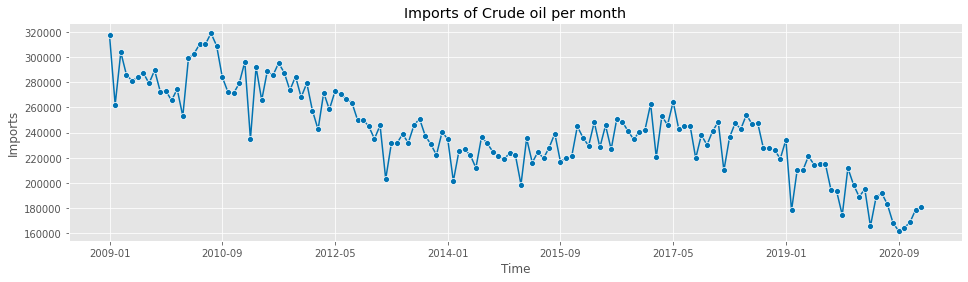

In [3]:
from sktime.utils.plotting import plot_series

plot_series(TS.Imports)
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [4]:
Train, Test = TS[:-12], TS[-12:]
print(f'Train shape:{Train.shape};  Test shape:{Test.shape}')

Train shape:(133, 1);  Test shape:(12, 1)


Изобразим Train и Test выборку

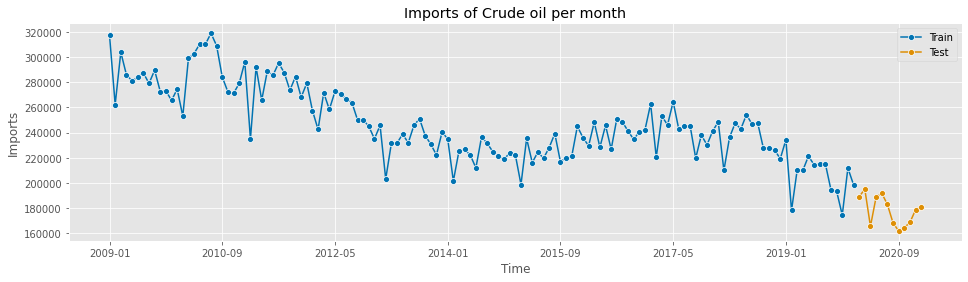

In [5]:
plot_series(Train.Imports, Test.Imports, labels=['Train', 'Test'])
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

Автокорреляционная функция ряда выглядит следующим образом

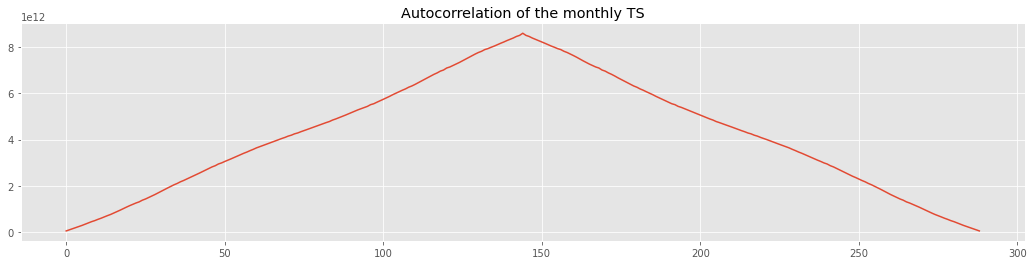

In [6]:
ACF = np.correlate(TS.Imports, TS.Imports, mode='full')

plt.figure(figsize=(18, 4))
plt.plot(ACF)
plt.title('Autocorrelation of the monthly TS')
plt.show()

Теперь изобразим наложения для рада, чтобы можно было наблюдать сезонность

In [7]:
colors = sns.color_palette("tab10")

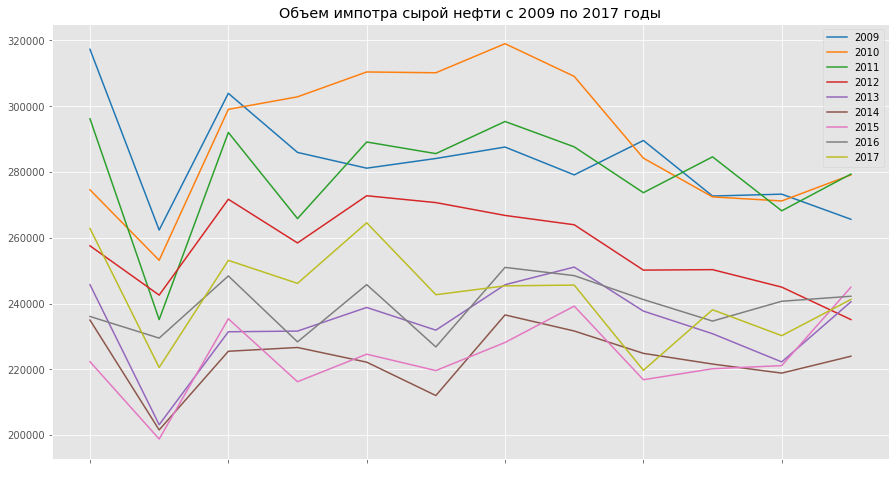

In [8]:
years = []
for i in range(0, 97, 12):
    y = Train.Imports.values[i: i+12]
    years.append(y)

plt.figure(figsize=(15, 8))
for i in range(9):
    k = i + 9
    year = f'20{k}' if k // 10 == 1 else f'200{k}'
    plt.plot(years[i], c=colors[i], label=year)

plt.title('Объем импотра сырой нефти с 2009 по 2017 годы')
plt.legend()
plt.xticks(color='w')
plt.show()

In [9]:
delta = TS.Imports.values[1:] - TS.Imports.values[:-1]
delta_df = pd.DataFrame(data=delta, index=TS.index.values[1:], columns=["Imports"])
delta_df.head()

,Imports
2009-02,-54936
2009-03,41558
2009-04,-17963
2009-05,-4787
2009-06,2946


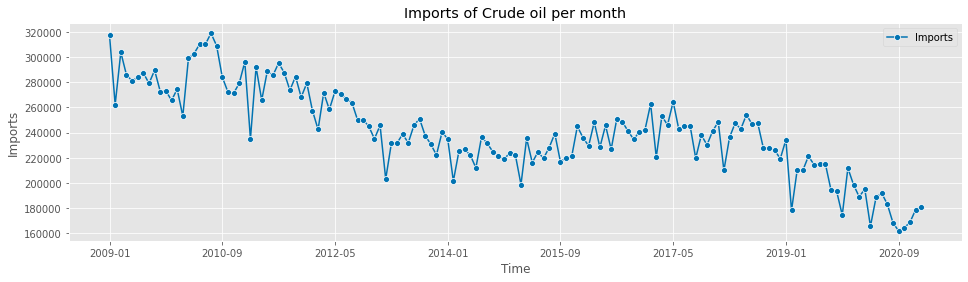

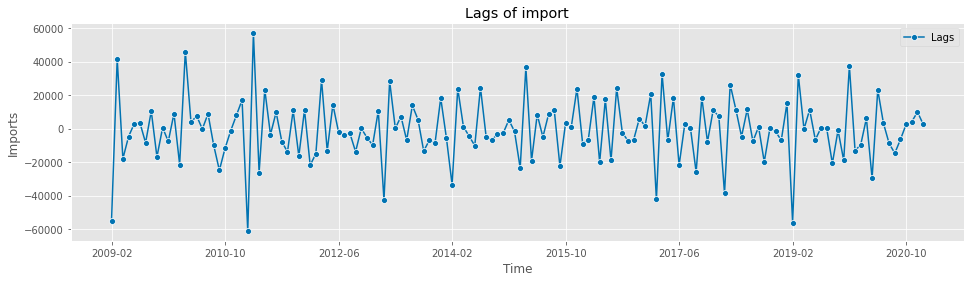

In [10]:
_, ax1 = plot_series(TS.Imports, labels=['Imports'])
ax1.set_title('Imports of Crude oil per month')
ax1.set_xlabel('Time')

_, ax2 = plot_series(delta_df.Imports, markers='o', labels=['Lags'])
ax2.set_title('Lags of import')
ax2.set_xlabel('Time')
plt.show()

Очевидно, что сам ряд нестационарный, и у него есть тренд, однако ряд лагов первого порядка уже похож на стационарный ряд

## NaiveForecaster из sktime.

Посчитаем предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t+1 - 12}$

In [55]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(Test.index, is_relative=False)
fh

ForecastingHorizon(['2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
             '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01'],
            dtype='period[M]', name='Date', freq='M', is_relative=False)

В первом случае предсказание просто равно предыдущему щначению 

In [12]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь
NF_1 = NaiveForecaster(strategy='last')
NF_1.fit(Train.Imports)
monthly_pred = NF_1.predict(fh=fh)

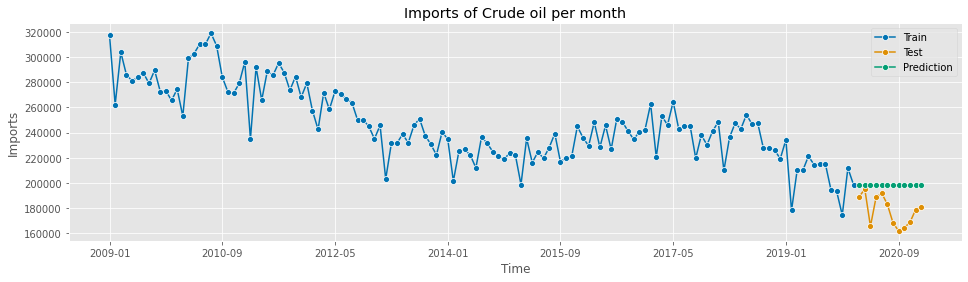

In [13]:
plot_series(Train.Imports, Test.Imports, monthly_pred, labels=["Train", "Test", "Prediction"])
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [14]:
# посчитайте метрики на test
from sklearn.metrics import mean_absolute_error as MAE

MAE(monthly_pred, Test.Imports.values)

20596.25

Во втором случае добавим сезонность к предсказанию ряда

In [15]:
NF_2 = NaiveForecaster(strategy='last', sp=12)
NF_2.fit(Train.Imports)
monthly_pred = NF_2.predict(fh=fh)

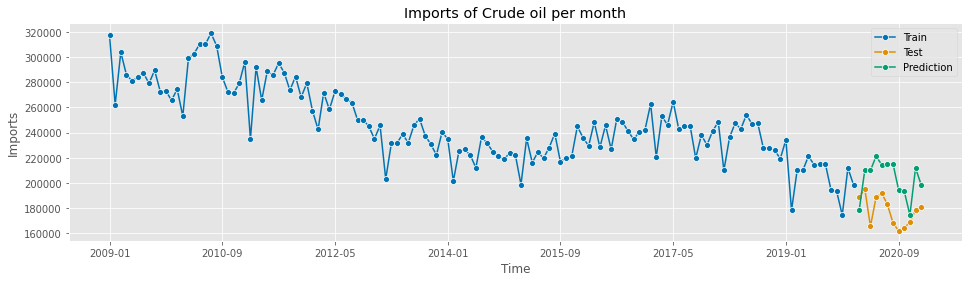

In [16]:
plot_series(Train.Imports, Test.Imports, monthly_pred, labels=["Train", "Test", "Prediction"])
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [ ]:
MAE(monthly_pred, Test.Imports.values)

26873.583333333332

## ARIMA/AutoArima.


* SARIMA(1, 1, 1)(1, 0, 0)[12] 
* Алгоритм Хиндмана-Хандакара подбора SARIMA 

In [17]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ваш код обучения моделей здесь
sarima = ARIMA(order=(1, 1, 1,), seasonal_order=(1, 0, 0, 12))
sarima.fit(Train.Imports)
monthly_pred = sarima.predict(fh=fh)

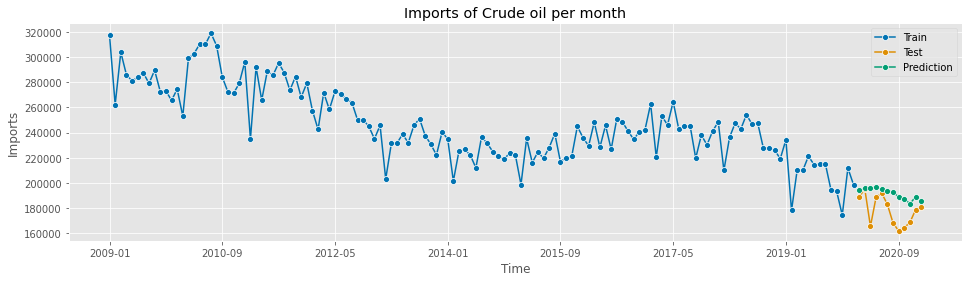

In [19]:
plot_series(Train.Imports, Test.Imports, monthly_pred, labels=["Train", "Test", "Prediction"])
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [21]:
# посчитайте метрики на test
MAE(monthly_pred, Test.Imports.values)

13576.468017658239

In [22]:
import pmdarima as pm

autoarima = pm.auto_arima(

    Train.Imports,
    start_p=1, start_q=1,
    max_p=5, max_q=5, 
    
    seasonal=True, m=12,
    start_P=0, start_Q=0,
    max_P =2 , max_Q = 2,
    
    max_D=2, max_d=2,
    alpha=0.05,   
    
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=False, 
    n_fits=100,
    information_criterion='aic',
    out_of_sample_size=7
)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2981.323, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2971.813, Time=0.14 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2959.034, Time=0.40 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2967.157, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2954.046, Time=0.22 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2955.740, Time=0.55 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=2956.043, Time=0.33 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=2955.547, Time=0.66 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2950.216, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2938.987, Time=0.21 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2928.417, Time=1.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2935.387, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2931.058, Time=0.31 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=2929.829, Time=1.00 sec


In [23]:
y_pred = autoarima.predict(n_periods=12)
monthly_pred = pd.Series(y_pred, fh)

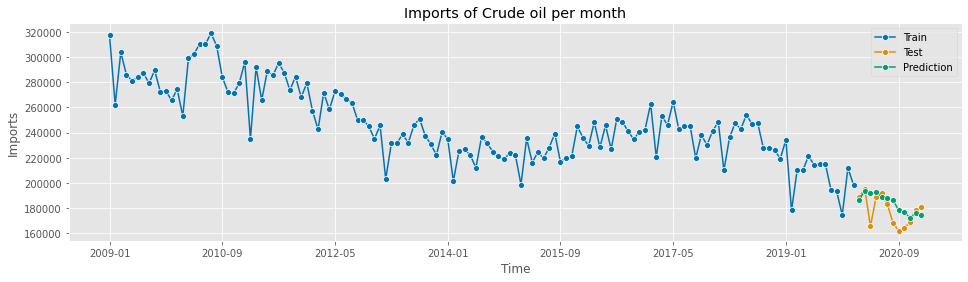

In [24]:
plot_series(Train.Imports, Test.Imports, monthly_pred, labels=["Train", "Test", "Prediction"])
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [26]:
# посчитайте метрики на test
MAE(monthly_pred, Test.Imports.values)

8487.687366683009

## ETS.


* ETS(AAA)
* ETS с автоматическим выбором по AIC

In [27]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

In [30]:
ETS = ExponentialSmoothing(
    trend='add', 
    seasonal='add', 
    sp=12, 
    use_boxcox = 0.3
)
ETS.fit(Train.Imports)
monthly_pred = ETS.predict(fh=fh)

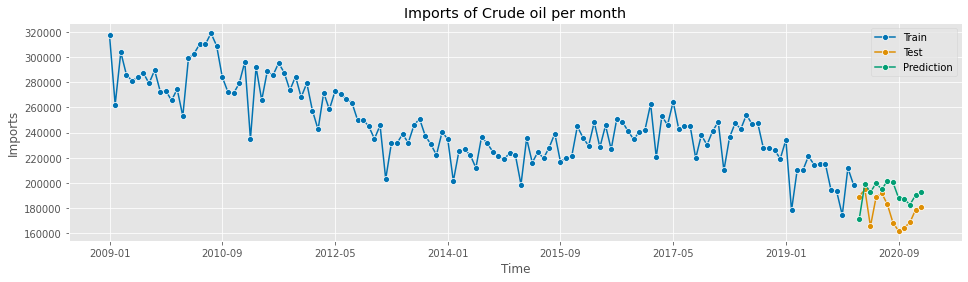

In [31]:
plot_series(Train.Imports, Test.Imports, monthly_pred, labels=["Train", "Test", "Prediction"])
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [33]:
# посчитайте метрики на test
MAE(monthly_pred, Test.Imports.values)

16669.76876916051

In [40]:
auto_ETS = AutoETS(
    error='add', 
    trend='add',
    seasonal='add',
    sp=12, 
    auto=True, 
    information_criterion='aic'
)
auto_ETS.fit(pd.Series(Train.Imports, dtype='float64'))
monthly_pred = auto_ETS.predict(fh=fh)

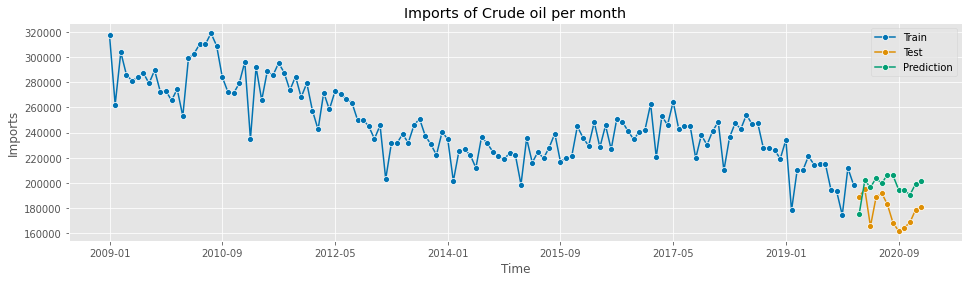

In [41]:
plot_series(Train.Imports, Test.Imports, monthly_pred, labels=["Train", "Test", "Prediction"])
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [43]:
MAE(monthly_pred, Test.Imports.values)

21727.42207557471

## Лучшая модель и прогнозирования на 2021-й год

Нарисуем теперь предсказания лучшей модели:
лучшая модель `**ARIMA**(1,1,0)(1,0,1)[12]`

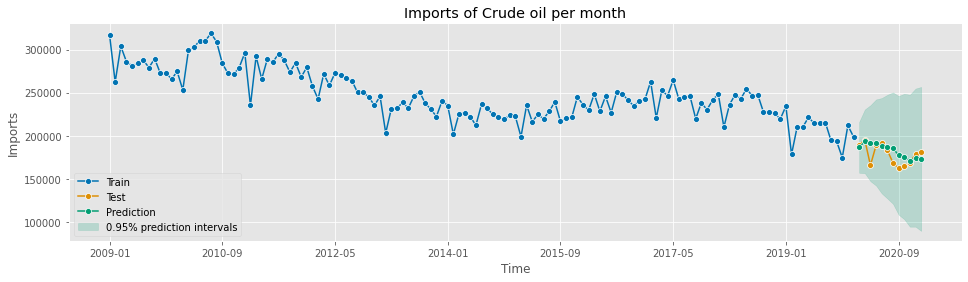

In [42]:
best_model = ARIMA(
    order = (1,1,0),
    seasonal_order = (1,0,1,12)
)
best_model.fit(Train.Imports)
best, pred_ints = best_model.predict(fh=fh, return_pred_int=True, alpha=0.05)

fig, ax = plot_series(Train.Imports, Test.Imports, best, labels=["Train", "Test", "Prediction"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - 0.05}% prediction intervals",
)
ax.legend(loc = "lower left")
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

In [44]:
MAE(Test.Imports.values, best)

8282.014421180806

Теперь загрузим в модель все данные и сделаем предсказание на год вперед

In [56]:
dates = pd.PeriodIndex(['2021-01', '2021-02', '2021-03', '2021-04', '2021-05',' 2021-06', '2021-07', 
                     '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01'], freq='M')
forcast_h = ForecastingHorizon(dates, is_relative=False)
forcast_h

ForecastingHorizon(['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
             '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
             '2022-01'],
            dtype='period[M]', freq='M', is_relative=False)

In [57]:
forecaster = ARIMA(
    order = (1,1,0),
    seasonal_order = (1,0,1,12)
)
forecaster.fit(Train.Imports)
forcast, CI = forecaster.predict(fh=forcast_h, return_pred_int=True, alpha=0.05)

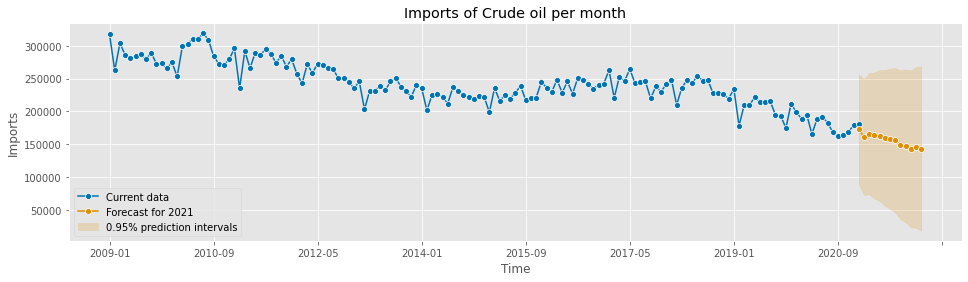

In [60]:
fig, ax = plot_series(TS.Imports, forcast, labels=["Current data", "Forecast for 2021"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    CI["lower"],
    CI["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - 0.05}% prediction intervals",
)
ax.legend(loc = "lower left")
plt.title('Imports of Crude oil per month')
plt.xlabel('Time')
plt.show()

## Бонус: Кроссвалидация 

мы не будем сравнивать все модели, а будем сравнивать только те 3, которые дали лучший результат: `ETS(AAA)`, `ARIMA(1,1,0)(1,0,1)[12]`, `NaiveFoecaster(sp=12)`

In [77]:
from collections import defaultdict
errors = defaultdict(list)

for i in range(12):
    train_cv, test_cv = TS.iloc[-118: -12+i], TS.iloc[-12+i]
    #ARIMA
    arima = ARIMA(order=(1,1,0), 
                  seasonal_order=(1,0,1,12))
    arima.fit(Train.Imports)
    y_arima = best_model.predict(fh=1)
    errors['arima'].append(MAE(test_cv, y_arima))

    #ETS
    ETS = ExponentialSmoothing(
                trend='add', 
                seasonal='add', 
                sp=12, 
                use_boxcox = 0.3)
    ETS.fit(Train.Imports)
    y_ETS = ETS.predict(fh=1)
    errors['ETS'].append(MAE(test_cv, y_ETS))

    # NaiveForecaster
    NF = NaiveForecaster(strategy='last', sp=12)
    NF.fit(Train.Imports)
    y_NF = NF.predict(fh=1)
    errors['NF'].append(MAE(test_cv, y_NF))


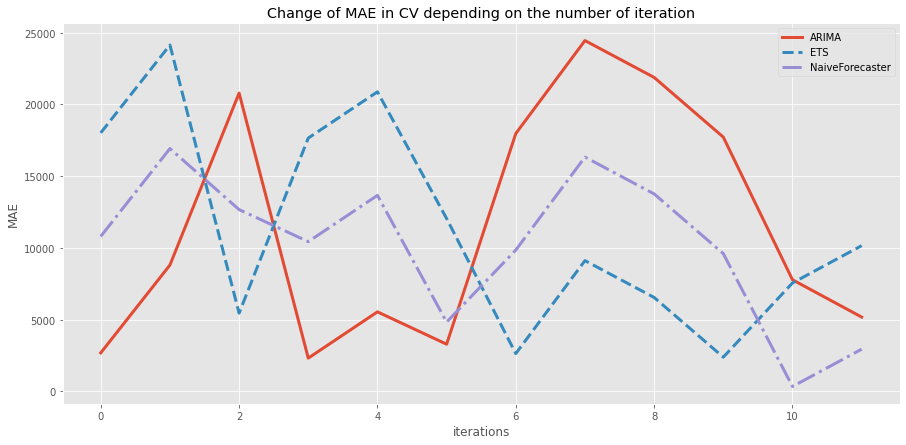

In [89]:
plt.figure(figsize=(15, 7))
plt.plot(errors['arima'],  lw=3, label='ARIMA')
plt.plot(errors['ETS'], ls='--',  lw=3, label='ETS')
plt.plot(errors['NF'], ls='-.',  lw=3, label='NaiveForecaster')
plt.ylabel('MAE')
plt.xlabel('iterations')
plt.title('Change of MAE in CV depending on the number of iteration')
plt.legend()
plt.show()

### Вывод: 
У ЕТS и NaiveForecaster ошибка падает, а у  ARIMA ошибка относительно стабильна

# **Часть II: Панельные данные**

## 1. Загрузка и предобработка 

In [165]:
def preprocess(string):
    arr = string.values
    for i in range(len(arr)):
        try:
            arr[i] = np.float64(arr[i])
        except ValueError:
            arr[i] = np.NaN
    return arr

In [206]:
df_panel = pd.read_csv("panel_data.csv", sep=',', parse_dates=True)
del df_panel['E17']
df_panel.head()

,ID_W,REDID_H,C1_1,C5_1,C6
0,2010 год,1038,ЗАТРУДНЯЮСЬ ОТВЕТИТЬ,2,52.70000000000000284
1,2010 год,1039,1800000,1,72
2,2010 год,1040,ЗАТРУДНЯЮСЬ ОТВЕТИТЬ,1,29.30000000000000071
3,2010 год,1041,ЗАТРУДНЯЮСЬ ОТВЕТИТЬ,2,52.89999999999999858
4,2010 год,1042,1300000,1,40.60000000000000142


In [207]:
df_panel['ID_W'] = df_panel['ID_W'].apply(lambda x: int(x.split()[0]))
df_panel['Year'] = df_panel['ID_W'] #pd.PeriodIndex(df_panel['ID_W'], freq='Y')

del df_panel['ID_W']
df_panel.apply(lambda x: preprocess(x))
df_panel = df_panel.dropna()

df_panel.columns = ['ID', 'Apart_price', 'N_rooms', 'Liv_space', 'Year']
df_panel = df_panel[['ID', 'Year', 'N_rooms', 'Liv_space', 'Apart_price']]

df_panel = df_panel.apply(pd.to_numeric)
df_panel.head()

,ID,Year,N_rooms,Liv_space,Apart_price
1,1039,2010,1.0,72.0,1800000.0
4,1042,2010,1.0,40.6,1300000.0
7,1045,2010,4.0,88.2,2000000.0
18,1056,2010,1.0,33.0,1000000.0
19,1057,2010,2.0,47.0,400000.0


In [210]:
unique_id = set(df_panel[df_panel.Year==2010].ID.values)
for y in df_panel.Year.unique():
    ids = df_panel[df_panel.Year==y].ID.values
    unique_id.intersection_update(ids)

df_panel.ID = df_panel.ID.apply(lambda x: 
                                x if x in unique_id 
                                else np.NaN)
df_panel = df_panel.dropna()
df_panel.ID = np.array(df_panel.ID, dtype=np.int16)
year, id = df_panel.Year, df_panel.ID
df_panel = df_panel.set_index(["ID", "Year"])
df_panel["Year"] = year.values
df_panel["ID"] = id.values
df_panel

,,N_rooms,Liv_space,Apart_price,Year,ID
ID,Year,,,,,
1057,2010,2.0,47.0,400000.0,2010,1057
1059,2010,3.0,72.0,1000000.0,2010,1059
1836,2010,2.0,42.5,2000000.0,2010,1836
1890,2010,1.0,28.0,120000.0,2010,1890
3292,2010,3.0,60.0,1400000.0,2010,3292
...,...,...,...,...,...,...
4134,2019,2.0,45.2,1800000.0,2019,4134
4152,2019,3.0,60.0,2500000.0,2019,4152
4156,2019,1.0,32.0,1200000.0,2019,4156


## 2. Визуальное исследование 

Сначала сформулируем исследовательский вопрос: **влияет ли количество комнат в квартире и площадь на цену квартиры ?** 

In [211]:
plt.style.use('seaborn')

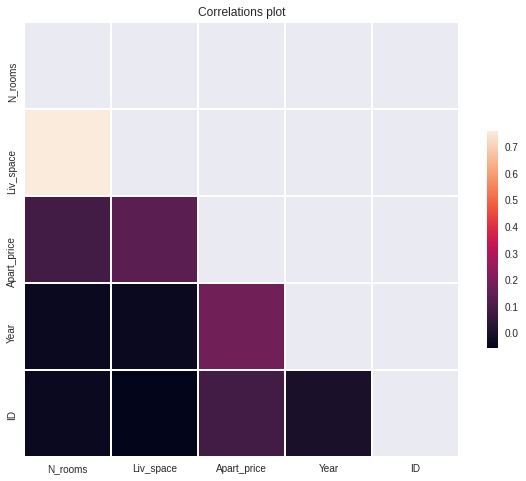

In [212]:
corr = df_panel.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))


plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},)
plt.title("Correlations plot")
plt.show()

Изобразим распределения цен на квартиры, количества комнат и жилой площади

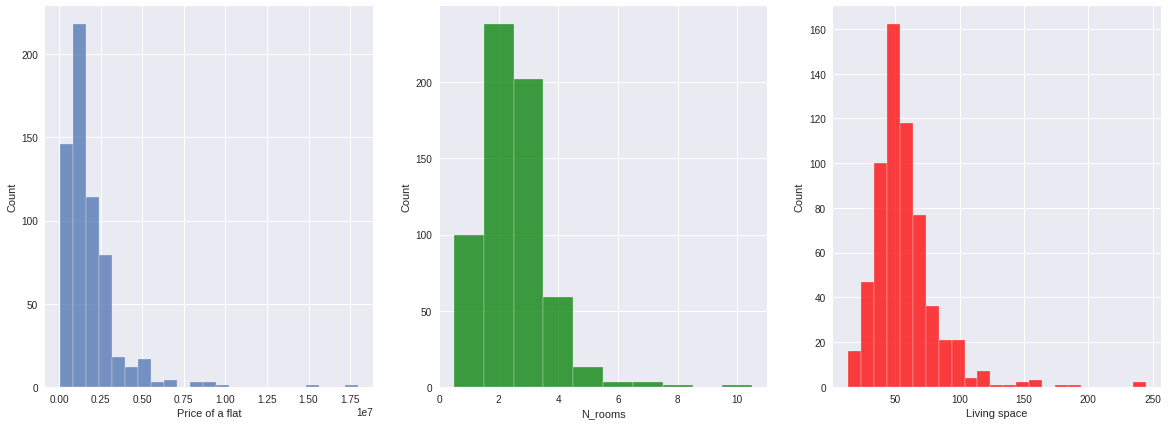

In [213]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7), sharey=False)

sns.histplot(df_panel.Apart_price.values, bins=23, ax=ax1)
ax1.set_xlabel('Price of a flat')

sns.histplot(x=df_panel.N_rooms, discrete=True, color='g', ax=ax2)

sns.histplot(df_panel.Liv_space.values, color='r', bins=23, ax=ax3)
ax3.set_xlabel('Living space')

plt.show()

Изобразим зависимость стоимости квартиры от числа комнат и жилой площади для разных людей

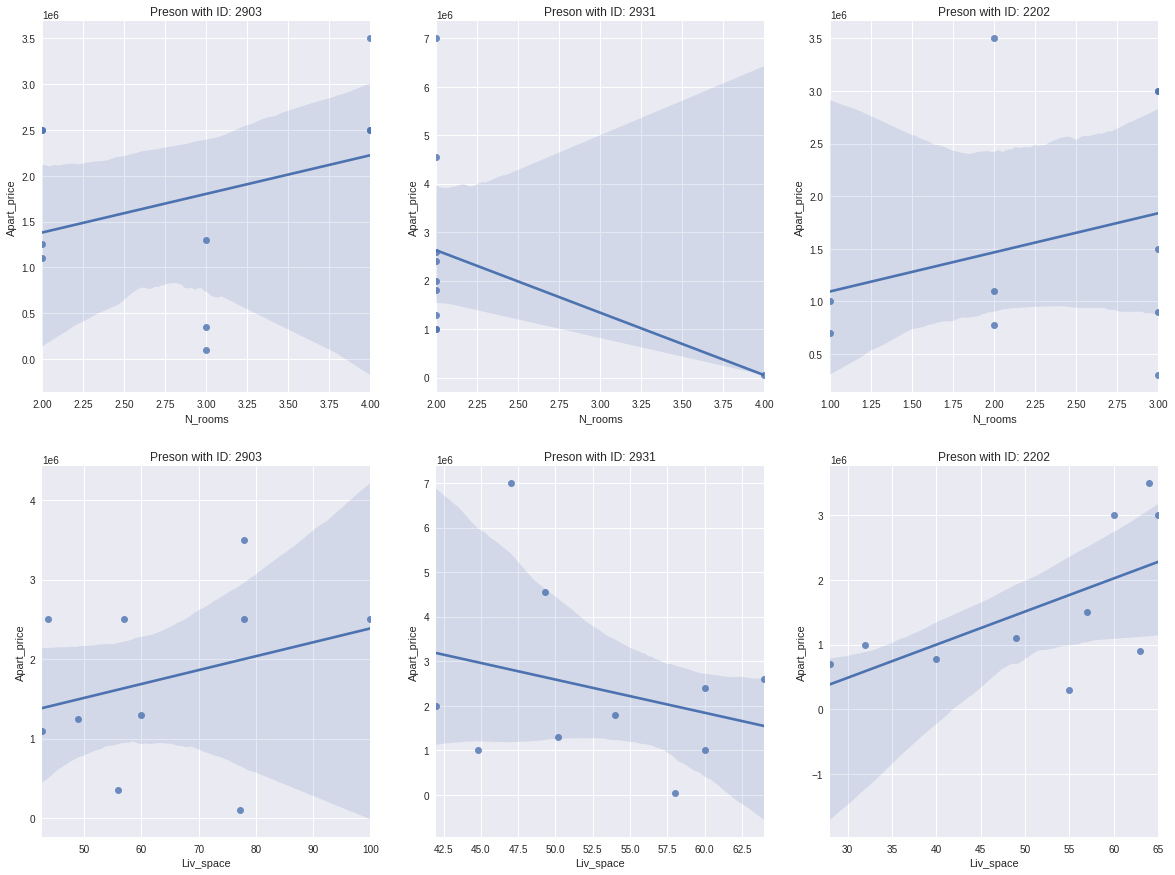

In [249]:
sample_idxs = np.random.randint(0, len(unique_id), size=3)
sample_ids = np.array(list(unique_id))[sample_idxs]

_, ax = plt.subplots(2, 3, figsize=(20, 15), sharey=False)
for i, id in enumerate(sample_ids):
    sns.regplot(x="N_rooms", y="Apart_price", data=df_panel[df_panel.ID==id], ax=ax[0, i%3])
    ax[0, i%3].set_title(f'Preson with ID: {id}')

    sns.regplot(x="Liv_space", y="Apart_price", data=df_panel[df_panel.ID==id], ax=ax[1, i%3])
    ax[1, i%3].set_title(f'Preson with ID: {id}')

Запишем теперь регрессоры и целевые переменные в `regressors` и `target`

In [250]:
# target variable 
target = df_panel[['Apart_price']]

# regressors
exog_vars = ['Liv_space', 'N_rooms']
regressors = sm.add_constant(df_panel[exog_vars])

## 3. Перейдем к построению моделей

In [251]:
pip install -q linearmodels statsmodels

In [252]:
from linearmodels.panel.model import PanelOLS, RandomEffects, PooledOLS
import statsmodels.api as sm

### 3.1 PooledOLS

In [253]:
pOLS = PooledOLS(target, regressors)
pOLS_res = pOLS.fit()
print(pOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:            Apart_price   R-squared:                        0.0191
Estimator:                  PooledOLS   R-squared (Between):              0.0154
No. Observations:                 620   R-squared (Within):               0.0197
Date:                Tue, Jun 08 2021   R-squared (Overall):              0.0191
Time:                        15:26:07   Log-likelihood                   -9744.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.0134
Entities:                          62   P-value                           0.0026
Avg Obs:                      10.0000   Distribution:                   F(2,617)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             6.0134
                            

### 3.2 Fixed Effects Model

In [254]:
FE = PanelOLS(target, regressors, 
              entity_effects=True, 
              time_effects=True)
FE_res = FE.fit()
print(FE_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Apart_price   R-squared:                        0.0213
Estimator:                   PanelOLS   R-squared (Between):              0.0103
No. Observations:                 620   R-squared (Within):               0.0200
Date:                Tue, Jun 08 2021   R-squared (Overall):              0.0186
Time:                        15:26:10   Log-likelihood                   -9665.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.9391
Entities:                          62   P-value                           0.0028
Avg Obs:                      10.0000   Distribution:                   F(2,547)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             5.9391
                            

### 3.3 Random Effects Model



In [255]:
RE = RandomEffects(target, regressors)
RE_res = RE.fit()
print(RE_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:            Apart_price   R-squared:                        0.0193
Estimator:              RandomEffects   R-squared (Between):              0.0143
No. Observations:                 620   R-squared (Within):               0.0199
Date:                Tue, Jun 08 2021   R-squared (Overall):              0.0191
Time:                        15:26:12   Log-likelihood                   -9727.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6.0863
Entities:                          62   P-value                           0.0024
Avg Obs:                      10.0000   Distribution:                   F(2,617)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             6.0863
                            

### Вывод:
Для определения лучшей модели можно использовать, например, критерий Акаике $AIC = 2k - ln(L)$:

pooled OLS AIC = 19494

fixed effecs AIC = 19316

random effecs  AIC = 19460

Таким образом, лучшая модель - модель Fixed Effects